# Face Alignment Preprocessor for Selfie Timelapse

This notebook preprocesses selfie images by aligning faces based on eye positions to create consistent face timelapses. The process involves detecting faces, extracting eye landmarks, and applying geometric transformations to align all faces uniformly.

## 1. Import Required Libraries

Import necessary libraries including OpenCV, dlib, NumPy, PIL, and os for image processing and face detection.

In [1]:
# --- INSTALL ALL REQUIRED PACKAGES ---
# This line checks if the packages are installed and installs them if they are not.
# It's a good practice to run this line in a new notebook to ensure a consistent environment.
!pip install https://github.com/omwaman1/dlib_wheel_for_python/releases/download/dlib-python3.13.5/dlib-20.0.0-cp313-cp313-win_amd64.whl opencv-python numpy matplotlib

# --- IMPORT ALL REQUIRED PACKAGES ---
import dlib
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from pathlib import Path


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached https://github.com/omwaman1/dlib_wheel_for_python/releases/download/dlib-python3.13.5/dlib-20.0.0-cp313-cp313-win_amd64.whl (2.9 MB)


## 2. Set Up Directory Paths

Define input and output directory paths. Select folders to process here.

In [2]:
# Define directory paths
base_dir = Path.cwd()

#############################
### CONFIGURATION SECTION
#############################

# Choose your processing mode:
PROCESSING_MODE = "PRODUCTION"  # Options: "TEST" or "PRODUCTION"

# For PRODUCTION mode: Select specific folders to process
# Leave empty [] to process ALL folders, or specify folders like: ["2023", "2024"]
SELECTED_FOLDERS = ["2025"]  # Change this to select which years/folders to process

#############################
### END CONFIGURATION SECTION
#############################

if PROCESSING_MODE == "TEST":
    source_base_dir = base_dir / "test_sorted_selfies"
    output_base_dir = base_dir / "test_output_selfies"
else:  # PRODUCTION
    source_base_dir = base_dir / "2_sorted_selfies"
    output_base_dir = base_dir / "3_output_selfies"

# Create output directory if it doesn't exist
output_base_dir.mkdir(parents=True, exist_ok=True)

print(f"🔧 Processing Mode: {PROCESSING_MODE}")
print(f"📁 Source base directory: {source_base_dir}")
print(f"📁 Output base directory: {output_base_dir}")
print(f"📁 Source directory exists: {source_base_dir.exists()}")

# Find all subdirectories in the source directory
all_subdirectories = []
if source_base_dir.exists():
    # First check if there are subdirectories
    for item in source_base_dir.iterdir():
        if item.is_dir():
            all_subdirectories.append(item)
    
    all_subdirectories.sort()
    
    if all_subdirectories:
        print(f"\n📋 Found {len(all_subdirectories)} total subdirectories:")
        for folder in all_subdirectories:
            print(f"  - {folder.name}")
        
        # Apply folder selection filter
        if PROCESSING_MODE == "PRODUCTION" and SELECTED_FOLDERS:
            subdirectories = [folder for folder in all_subdirectories if folder.name in SELECTED_FOLDERS]
            print(f"\n🎯 Selected folders to process: {SELECTED_FOLDERS}")
            print(f"✅ Will process {len(subdirectories)} folders:")
            for folder in subdirectories:
                print(f"  - {folder.name}")
            
            # Check if any selected folders don't exist
            missing_folders = [name for name in SELECTED_FOLDERS if name not in [f.name for f in all_subdirectories]]
            if missing_folders:
                print(f"⚠️  Warning: These selected folders don't exist: {missing_folders}")
        else:
            subdirectories = all_subdirectories
            print(f"\n📂 Processing ALL {len(subdirectories)} folders")
    else:
        print("No subdirectories found - will search root directory")
        subdirectories = [source_base_dir]  # Use root directory itself
else:
    print("⚠️  Source directory does not exist!")
    subdirectories = []

print(f"\n🚀 Ready to process {len(subdirectories)} folder(s)")

🔧 Processing Mode: PRODUCTION
📁 Source base directory: c:\Users\Chimeng62\Desktop\daily_selfie_preprocessor_notebook\2_sorted_selfies
📁 Output base directory: c:\Users\Chimeng62\Desktop\daily_selfie_preprocessor_notebook\3_output_selfies
📁 Source directory exists: True

📋 Found 4 total subdirectories:
  - 2022
  - 2023
  - 2024
  - 2025

🎯 Selected folders to process: ['2025']
✅ Will process 1 folders:
  - 2025

🚀 Ready to process 1 folder(s)


## 3. Load and Display Test Images

Load images from all subdirectories in the source folder and display them to verify the input data.

In [3]:
# Get list of image files from all subdirectories
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
image_files = []

print("Loading images from all subdirectories...")

for directory in subdirectories:
    dir_images = []
    for ext in image_extensions:
        dir_images.extend(list(directory.glob(f'*{ext}')))
        dir_images.extend(list(directory.glob(f'*{ext.upper()}')))
    
    # Also search recursively for images in subdirectories
    for ext in image_extensions:
        dir_images.extend(list(directory.glob(f'**/*{ext}')))
        dir_images.extend(list(directory.glob(f'**/*{ext.upper()}')))
    
    # Remove duplicates while preserving order
    dir_images = list(dict.fromkeys(dir_images))
    
    folder_name = directory.name if directory != source_base_dir else "root"
    print(f"  {folder_name}: {len(dir_images)} images")
    image_files.extend(dir_images)

# Sort all images by filename
image_files.sort()

print(f"\nTotal images found: {len(image_files)}")
if image_files:
    print("First 5 images:")
    for i, img_path in enumerate(image_files[:5]):
        # Get relative path from source base directory
        try:
            rel_path = img_path.relative_to(source_base_dir)
            print(f"{i+1}. {rel_path}")
        except ValueError:
            print(f"{i+1}. {img_path.name}")

    if len(image_files) > 5:
        print(f"... and {len(image_files) - 5} more")
    
    # Show distribution by directory
    from collections import defaultdict
    dir_counts = defaultdict(int)
    for img_path in image_files:
        if img_path.parent == source_base_dir:
            dir_name = "root"
        else:
            try:
                rel_parent = img_path.parent.relative_to(source_base_dir)
                dir_name = str(rel_parent).split('\\')[0] if '\\' in str(rel_parent) else str(rel_parent)
            except ValueError:
                dir_name = img_path.parent.name
        dir_counts[dir_name] += 1
    
    print(f"\nDistribution by directory:")
    for dir_name in sorted(dir_counts.keys()):
        print(f"  {dir_name}: {dir_counts[dir_name]} images")

Loading images from all subdirectories...
  2025: 227 images

Total images found: 227
First 5 images:
1. 2025\IMG20250514125945.jpg
2. 2025\IMG20250515141442.jpg
3. 2025\IMG20250517125640.jpg
4. 2025\IMG20250518122642.jpg
5. 2025\IMG20250520153626.jpg
... and 222 more

Distribution by directory:
  2025: 227 images


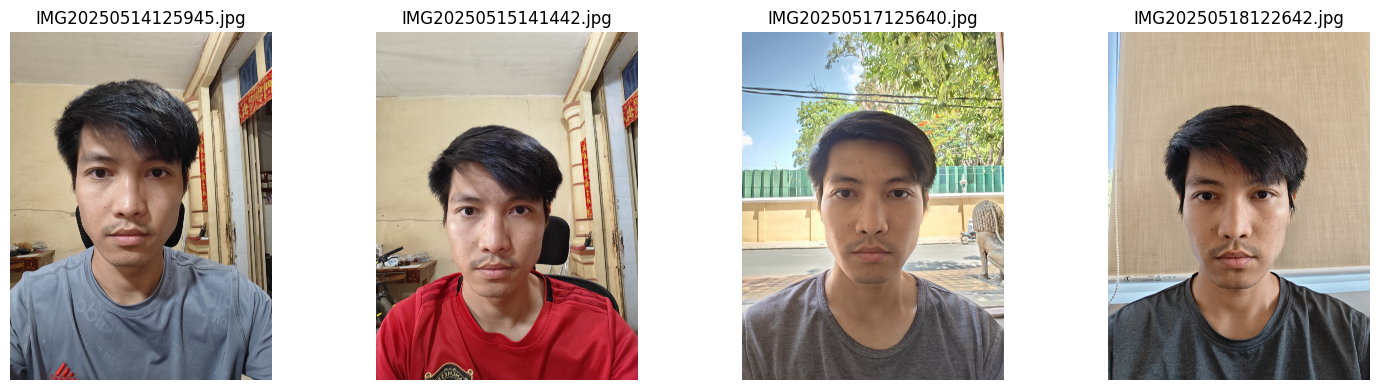

In [4]:
# Display first few images
def display_images(image_paths, max_images=4):
    fig, axes = plt.subplots(1, min(len(image_paths), max_images), figsize=(15, 4))
    if min(len(image_paths), max_images) == 1:
        axes = [axes]
    
    for i, img_path in enumerate(image_paths[:max_images]):
        img = cv2.imread(str(img_path))
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(img_path.name)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

if image_files:
    display_images(image_files[:4])
else:
    print("No images found in the source directory!")

## 4. Test dlib Functionality

Test if dlib is working properly and can detect faces and facial landmarks. This is crucial for the facial alignment pipeline.

=== TESTING DLIB FUNCTIONALITY ===
✅ dlib imported successfully
✅ dlib face detector initialized successfully
✅ dlib facial landmark predictor loaded successfully
   Using model: shape_predictor_68_face_landmarks.dat

🧪 Testing face detection on: IMG20250514125945.jpg
   Detected 1 face(s)
✅ Face detection working!
✅ Landmark detection working! Found 68 landmarks
   Detected 1 face(s)
✅ Face detection working!
✅ Landmark detection working! Found 68 landmarks


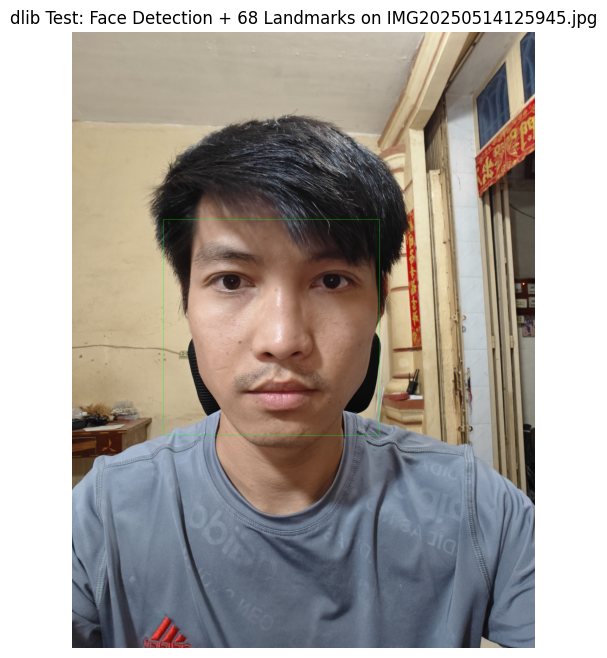

🎉 dlib is fully functional!
   Ready for facial alignment pipeline

📊 DLIB STATUS: ✅ READY


In [5]:
# Test dlib functionality
print("=== TESTING DLIB FUNCTIONALITY ===")

# Check if dlib is available
try:
    import dlib
    DLIB_AVAILABLE = True
    print("✅ dlib imported successfully")
except ImportError:
    DLIB_AVAILABLE = False
    print("❌ dlib not available")

# Initialize face detector
if DLIB_AVAILABLE:
    try:
        face_detector = dlib.get_frontal_face_detector()
        print("✅ dlib face detector initialized successfully")
        
        # Test landmark predictor
        predictor_path = "shape_predictor_68_face_landmarks.dat"
        predictor = None
        
        if os.path.exists(predictor_path):
            try:
                predictor = dlib.shape_predictor(predictor_path)
                print("✅ dlib facial landmark predictor loaded successfully")
                print(f"   Using model: {predictor_path}")
            except Exception as e:
                print(f"❌ Failed to load landmark predictor: {str(e)}")
        else:
            print("⚠️  Landmark predictor file not found!")
            print(f"   Expected location: {predictor_path}")
            print("   Download from: http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2")
            print("   Or download a prebuilt version and place it in the notebook directory")
        
        # Test face detection on first image if available
        if image_files:
            test_image_path = image_files[0]
            print(f"\n🧪 Testing face detection on: {test_image_path.name}")
            
            test_image = cv2.imread(str(test_image_path))
            test_image_gray = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
            
            # Detect faces
            faces = face_detector(test_image_gray)
            print(f"   Detected {len(faces)} face(s)")
            
            if len(faces) > 0:
                print("✅ Face detection working!")
                
                # Test landmark detection if predictor is available
                if predictor is not None:
                    face = faces[0]  # Use first detected face
                    landmarks = predictor(test_image_gray, face)
                    print(f"✅ Landmark detection working! Found {landmarks.num_parts} landmarks")
                    
                    # Visualize the results
                    test_image_vis = test_image.copy()
                    
                    # Draw face rectangle
                    x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
                    cv2.rectangle(test_image_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw landmarks
                    for i in range(landmarks.num_parts):
                        x = landmarks.part(i).x
                        y = landmarks.part(i).y
                        cv2.circle(test_image_vis, (x, y), 2, (0, 0, 255), -1)
                    
                    # Display result
                    plt.figure(figsize=(12, 8))
                    plt.imshow(cv2.cvtColor(test_image_vis, cv2.COLOR_BGR2RGB))
                    plt.title(f"dlib Test: Face Detection + 68 Landmarks on {test_image_path.name}")
                    plt.axis('off')
                    plt.show()
                    
                    print("🎉 dlib is fully functional!")
                    print("   Ready for facial alignment pipeline")
                else:
                    print("⚠️  Landmark detection unavailable - need shape_predictor_68_face_landmarks.dat")
            else:
                print("⚠️  No faces detected - try with a clearer selfie image")
        else:
            print("⚠️  No test images available")
            
    except Exception as e:
        print(f"❌ dlib face detector initialization failed: {str(e)}")
        DLIB_AVAILABLE = False
else:
    print("❌ dlib not available")
    print("   The advanced facial alignment pipeline requires dlib")
    print("   Please install dlib or use the basic OpenCV fallback")

print(f"\n📊 DLIB STATUS: {'✅ READY' if DLIB_AVAILABLE and 'predictor' in locals() and predictor is not None else '❌ NOT READY'}")

## 5. Face Detection

For each image, detect the face and isolate the region of interest for facial landmark detection.

=== STEP 5: FACE DETECTION ===
Processing 227 images for face detection...


Detecting faces: 100%|██████████| 227/227 [09:50<00:00,  2.60s/it]




📊 Face Detection Results:
✅ Successfully detected faces: 225/227
❌ Failed detections: 2

Failed images:
  - IMG20250802122138.jpg
  - IMG20250806130628.jpg

🖼️  Showing face detection on first 3 images:


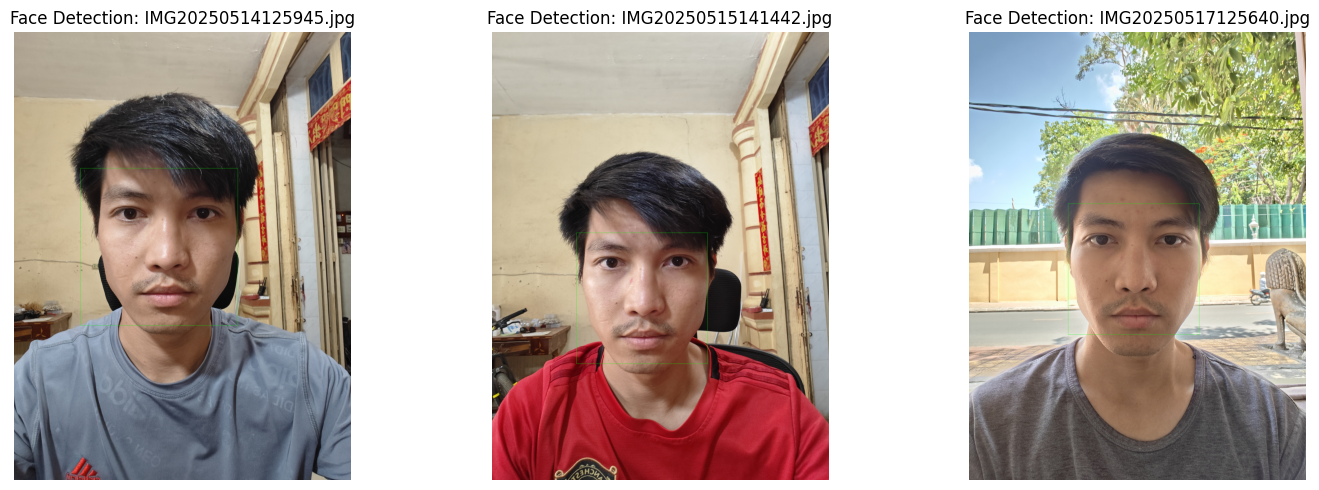

✅ Face detection completed successfully!
   Ready for landmark detection in next step


In [6]:
# Face Detection on all images
print("=== STEP 5: FACE DETECTION ===")

# Import tqdm for progress tracking
try:
    from tqdm import tqdm
except ImportError:
    # Fallback if tqdm not available
    def tqdm(iterable, desc="Processing"):
        print(f"{desc}...")
        return iterable

def detect_face_in_image(image_path):
    """
    Detect face in a single image.
    
    Args:
        image_path: Path to the image
    
    Returns:
        tuple: (image, gray_image, face_rect) or None if no face detected
    """
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            return None
        
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        faces = face_detector(gray)
        
        if len(faces) == 0:
            return None
        
        # Use the largest face if multiple faces detected
        largest_face = max(faces, key=lambda f: f.width() * f.height())
        
        return image, gray, largest_face
    except Exception as e:
        print(f"Error processing {image_path}: {str(e)}")
        return None

# Process all images for face detection
if 'DLIB_AVAILABLE' in locals() and DLIB_AVAILABLE and image_files:
    print(f"Processing {len(image_files)} images for face detection...")
    
    face_data = []
    failed_images = []
    
    for img_path in tqdm(image_files, desc="Detecting faces"):
        result = detect_face_in_image(img_path)
        if result is not None:
            image, gray, face_rect = result
            face_data.append({
                'path': img_path,
                'image': image,
                'gray': gray,
                'face': face_rect,
                'name': img_path.name
            })
        else:
            failed_images.append(img_path.name)
    
    print(f"\n📊 Face Detection Results:")
    print(f"✅ Successfully detected faces: {len(face_data)}/{len(image_files)}")
    print(f"❌ Failed detections: {len(failed_images)}")
    
    if failed_images:
        print(f"\nFailed images:")
        for name in failed_images[:5]:  # Show first 5
            print(f"  - {name}")
        if len(failed_images) > 5:
            print(f"  ... and {len(failed_images) - 5} more")
    
    # Visualize face detection results on a few samples
    if len(face_data) >= 3:
        print(f"\n🖼️  Showing face detection on first 3 images:")
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        
        for i in range(3):
            data = face_data[i]
            img_vis = data['image'].copy()
            face = data['face']
            
            # Draw face rectangle
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            axes[i].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Face Detection: {data['name']}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Face detection completed successfully!")
        print("   Ready for landmark detection in next step")
    else:
        print("⚠️  Need at least 3 successful face detections to proceed")
        
else:
    print("❌ Cannot proceed: dlib not available or no images found")
    print("   Please ensure dlib is working and images are loaded")

## 6. Facial Landmark Detection

Within each detected face, identify key facial landmarks such as eyes, nose, and mouth corners. These landmarks will be used to calculate the average face geometry.

=== STEP 6: FACIAL LANDMARK DETECTION ===
Extracting landmarks from 225 faces...


Extracting landmarks: 100%|██████████| 225/225 [00:08<00:00, 26.00it/s] 




📊 Landmark Detection Results:
✅ Successfully extracted landmarks: 225/225
❌ Failed extractions: 0

🎯 Showing landmarks on first 3 images:


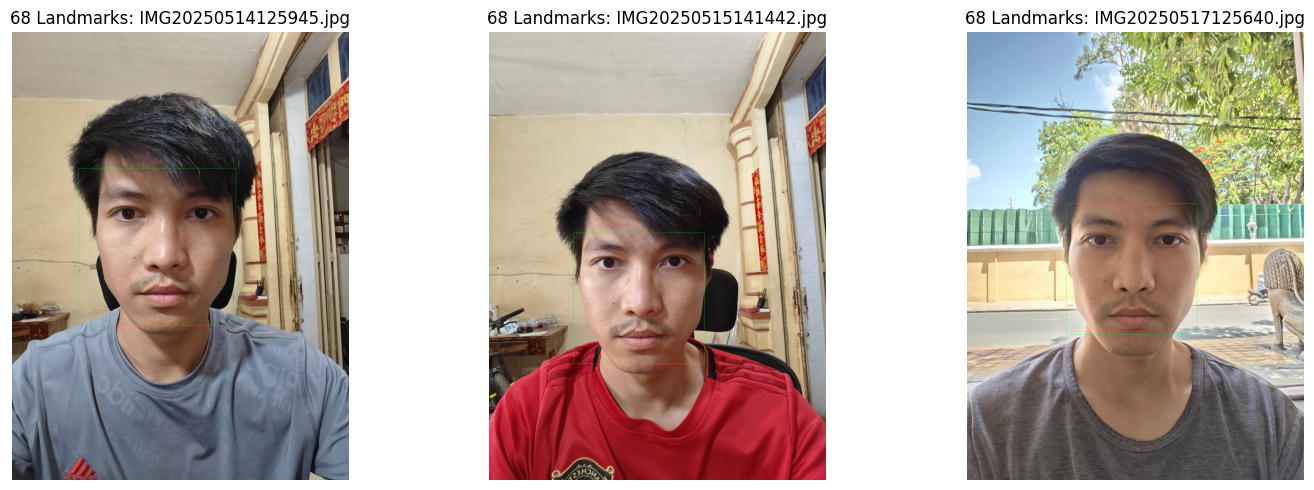


📈 Landmark Statistics:
   Total faces with landmarks: 225
   Landmarks per face: 68
   Landmark array shape: (225, 68, 2)
   Ready for average face calculation!


In [7]:
# Facial Landmark Detection
print("=== STEP 6: FACIAL LANDMARK DETECTION ===")

def extract_landmarks(gray_image, face_rect, predictor):
    """
    Extract 68 facial landmarks from a face.
    
    Args:
        gray_image: Grayscale image
        face_rect: Face rectangle from dlib
        predictor: dlib landmark predictor
    
    Returns:
        numpy array of shape (68, 2) with landmark coordinates
    """
    landmarks = predictor(gray_image, face_rect)
    points = np.array([(landmarks.part(i).x, landmarks.part(i).y) for i in range(68)])
    return points

# Extract landmarks from all detected faces
if ('DLIB_AVAILABLE' in locals() and DLIB_AVAILABLE and 
    'predictor' in locals() and predictor is not None and 
    'face_data' in locals()):
    print(f"Extracting landmarks from {len(face_data)} faces...")
    
    landmark_data = []
    failed_landmarks = []
    
    for data in tqdm(face_data, desc="Extracting landmarks"):
        try:
            landmarks = extract_landmarks(data['gray'], data['face'], predictor)
            landmark_data.append({
                'path': data['path'],
                'name': data['name'],
                'image': data['image'],
                'landmarks': landmarks,
                'face': data['face']
            })
        except Exception as e:
            failed_landmarks.append(data['name'])
            print(f"Failed to extract landmarks from {data['name']}: {str(e)}")
    
    print(f"\n📊 Landmark Detection Results:")
    print(f"✅ Successfully extracted landmarks: {len(landmark_data)}/{len(face_data)}")
    print(f"❌ Failed extractions: {len(failed_landmarks)}")
    
    if landmark_data:
        # Visualize landmarks on a few samples
        print(f"\n🎯 Showing landmarks on first 3 images:")
        
        fig, axes = plt.subplots(1, min(3, len(landmark_data)), figsize=(15, 5))
        if len(landmark_data) == 1:
            axes = [axes]
        
        for i in range(min(3, len(landmark_data))):
            data = landmark_data[i]
            img_vis = data['image'].copy()
            landmarks = data['landmarks']
            
            # Draw face rectangle
            face = data['face']
            x1, y1, x2, y2 = face.left(), face.top(), face.right(), face.bottom()
            cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            # Draw all 68 landmarks
            for (x, y) in landmarks:
                cv2.circle(img_vis, (int(x), int(y)), 2, (0, 0, 255), -1)
            
            # Highlight key points (eyes, nose tip, mouth corners)
            key_points = [36, 39, 42, 45, 30, 48, 54]  # Left eye, right eye, nose tip, mouth corners
            for idx in key_points:
                x, y = landmarks[idx]
                cv2.circle(img_vis, (int(x), int(y)), 4, (255, 255, 0), -1)
            
            axes[i].imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"68 Landmarks: {data['name']}")
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # Show landmark statistics
        all_landmarks = np.array([data['landmarks'] for data in landmark_data])
        print(f"\n📈 Landmark Statistics:")
        print(f"   Total faces with landmarks: {len(landmark_data)}")
        print(f"   Landmarks per face: 68")
        print(f"   Landmark array shape: {all_landmarks.shape}")
        print(f"   Ready for average face calculation!")
        
    else:
        print("❌ No landmarks extracted - cannot proceed with alignment")
        
else:
    print("❌ Cannot proceed: Missing predictor, dlib, or face data")
    print("   Please ensure previous steps completed successfully")

## 7. Calculate the "Average Face"

Calculate the average position for each landmark across all images. This creates a stable, consistent target geometry that represents the entire collection and will be used for alignment.

=== STEP 7: CALCULATE THE AVERAGE FACE ===
Calculating average from 225 faces...
Landmark array shape: (225, 68, 2)
Average landmarks shape: (68, 2)

📊 Average Face Statistics:
   Mean standard deviation X: 299.29 pixels
   Mean standard deviation Y: 668.14 pixels
   Total variance: 483.72 pixels

🎭 Visualizing the Average Face:


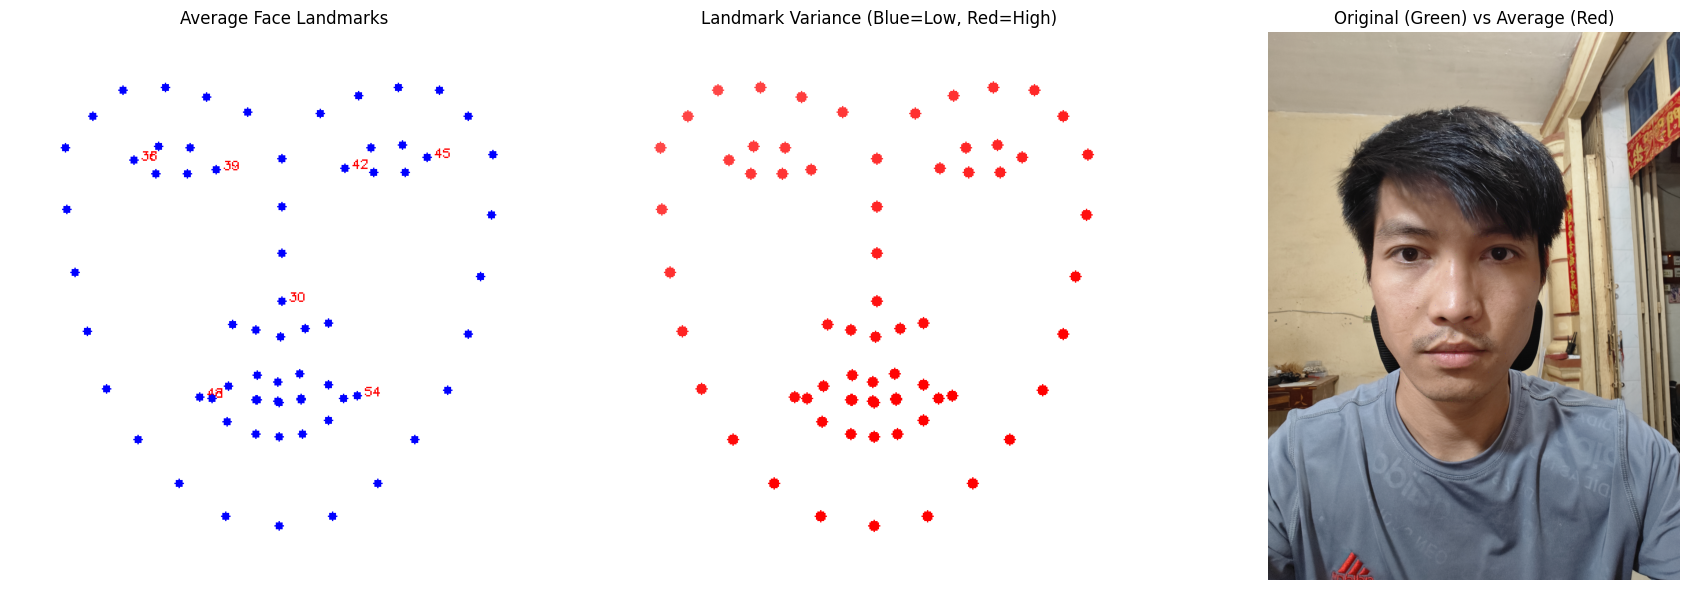


✅ Average face calculated successfully!
   Average landmarks ready for alignment step
   This will be the target geometry for all face alignments


In [8]:
# Calculate the Average Face
print("=== STEP 7: CALCULATE THE AVERAGE FACE ===")

if 'landmark_data' in locals() and len(landmark_data) > 0:
    # Collect all landmarks
    all_landmarks = np.array([data['landmarks'] for data in landmark_data])
    print(f"Calculating average from {len(landmark_data)} faces...")
    print(f"Landmark array shape: {all_landmarks.shape}")
    
    # Calculate mean landmarks
    average_landmarks = np.mean(all_landmarks, axis=0)
    print(f"Average landmarks shape: {average_landmarks.shape}")
    
    # Calculate standard deviation to understand variance
    landmark_std = np.std(all_landmarks, axis=0)
    
    # Calculate some statistics
    mean_std_x = np.mean(landmark_std[:, 0])
    mean_std_y = np.mean(landmark_std[:, 1])
    
    print(f"\n📊 Average Face Statistics:")
    print(f"   Mean standard deviation X: {mean_std_x:.2f} pixels")
    print(f"   Mean standard deviation Y: {mean_std_y:.2f} pixels")
    print(f"   Total variance: {np.mean(landmark_std):.2f} pixels")
    
    # Visualize the average face
    print(f"\n🎭 Visualizing the Average Face:")
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # 1. Show average landmarks on a blank canvas
    canvas_size = 400
    canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    
    # Scale and center the average landmarks to fit the canvas
    landmarks_scaled = average_landmarks.copy()
    landmarks_scaled = landmarks_scaled - np.min(landmarks_scaled, axis=0)  # Move to origin
    landmarks_scaled = landmarks_scaled / np.max(landmarks_scaled) * (canvas_size * 0.8)  # Scale to fit
    landmarks_scaled = landmarks_scaled + (canvas_size * 0.1)  # Add padding
    
    # Draw the average face landmarks
    for i, (x, y) in enumerate(landmarks_scaled):
        cv2.circle(canvas, (int(x), int(y)), 3, (255, 0, 0), -1)
        # Add numbers for key landmarks
        if i in [36, 39, 42, 45, 30, 48, 54]:  # Key points
            cv2.putText(canvas, str(i), (int(x)+5, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
    
    axes[0].imshow(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Average Face Landmarks")
    axes[0].axis('off')
    
    # 2. Show variance visualization (heatmap of standard deviation)
    variance_canvas = np.ones((canvas_size, canvas_size, 3), dtype=np.uint8) * 255
    
    # Color-code landmarks by their variance
    max_var = np.max(landmark_std)
    for i, ((x, y), (std_x, std_y)) in enumerate(zip(landmarks_scaled, landmark_std)):
        variance = np.sqrt(std_x**2 + std_y**2)
        intensity = int(255 * (1 - variance / max_var))  # Higher variance = redder
        color = (intensity, intensity, 255)  # Blue to red gradient
        cv2.circle(variance_canvas, (int(x), int(y)), 4, color, -1)
    
    axes[1].imshow(cv2.cvtColor(variance_canvas, cv2.COLOR_BGR2RGB))
    axes[1].set_title("Landmark Variance (Blue=Low, Red=High)")
    axes[1].axis('off')
    
    # 3. Show overlay of first image with average landmarks
    if len(landmark_data) > 0:
        first_image = landmark_data[0]['image'].copy()
        first_landmarks = landmark_data[0]['landmarks']
        
        # Draw original landmarks in green
        for (x, y) in first_landmarks:
            cv2.circle(first_image, (int(x), int(y)), 2, (0, 255, 0), -1)
        
        # Draw average landmarks in red (scaled to match first image)
        # Simple scaling based on face size
        face = landmark_data[0]['face']
        face_width = face.right() - face.left()
        face_height = face.bottom() - face.top()
        
        # Scale average landmarks to match first image
        avg_width = np.max(average_landmarks[:, 0]) - np.min(average_landmarks[:, 0])
        avg_height = np.max(average_landmarks[:, 1]) - np.min(average_landmarks[:, 1])
        
        scale_x = face_width / avg_width
        scale_y = face_height / avg_height
        scale = min(scale_x, scale_y)
        
        scaled_avg = average_landmarks * scale
        offset_x = face.left() + face_width/2 - (np.max(scaled_avg[:, 0]) + np.min(scaled_avg[:, 0]))/2
        offset_y = face.top() + face_height/2 - (np.max(scaled_avg[:, 1]) + np.min(scaled_avg[:, 1]))/2
        
        scaled_avg[:, 0] += offset_x
        scaled_avg[:, 1] += offset_y
        
        for (x, y) in scaled_avg:
            cv2.circle(first_image, (int(x), int(y)), 2, (255, 0, 0), -1)
        
        axes[2].imshow(cv2.cvtColor(first_image, cv2.COLOR_BGR2RGB))
        axes[2].set_title("Original (Green) vs Average (Red)")
        axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Store the average landmarks for use in alignment
    print(f"\n✅ Average face calculated successfully!")
    print(f"   Average landmarks ready for alignment step")
    print(f"   This will be the target geometry for all face alignments")
    
else:
    print("❌ Cannot calculate average face: No landmark data available")
    print("   Please ensure previous steps completed successfully")

## 8. Alignment and Normalization

For each individual selfie, calculate a geometric transformation (rotation, scaling, and translation) to align its landmarks to the corresponding average landmark positions. This transformation is then applied to the entire image.

=== STEP 8: ALIGNMENT AND NORMALIZATION ===
Aligning 225 images to average face...
Output size: (600, 600)
Scale factor: 0.137 (reduced from 0.8 to 0.5 for more head/hair)
Average face centered at: (182.4, 189.2)


Aligning images: 100%|██████████| 225/225 [00:46<00:00,  4.85it/s]




📊 Alignment Results:
✅ Successfully aligned: 225/225
❌ Failed alignments: 0

🔄 Before/After Comparison:


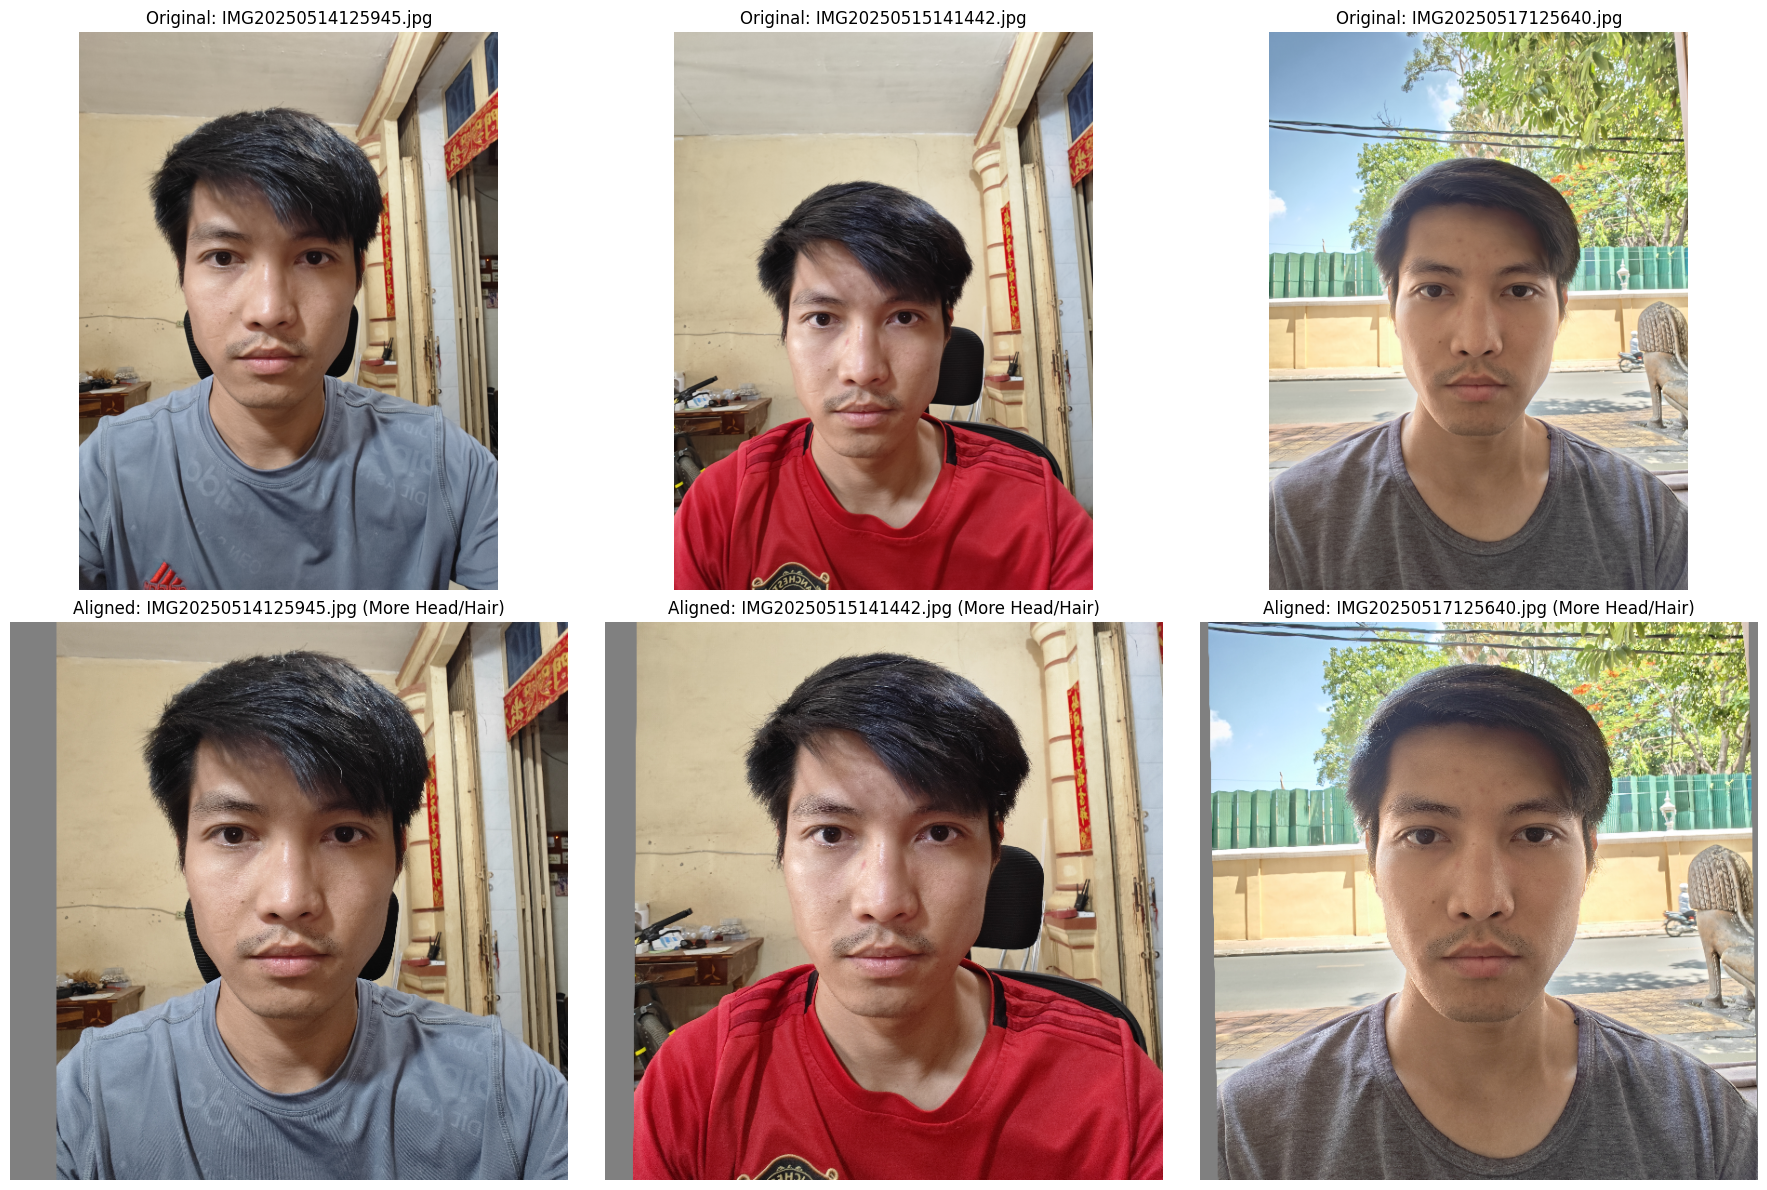

✅ Alignment completed successfully!
   All faces are now in the same position, scale, and rotation
   💡 Now showing more head and hair area!
   Ready for output generation in next step


In [9]:
# Alignment and Normalization
print("=== STEP 8: ALIGNMENT AND NORMALIZATION ===")

def calculate_transformation_matrix(source_landmarks, target_landmarks, method='similarity'):
    """
    Calculate transformation matrix to align source landmarks to target landmarks.
    
    Args:
        source_landmarks: (68, 2) array of source landmark coordinates
        target_landmarks: (68, 2) array of target landmark coordinates  
        method: 'similarity' (scale + rotation + translation) or 'affine' (more flexible)
    
    Returns:
        2x3 transformation matrix
    """
    
    # Use key facial landmarks for better alignment (eyes, nose, mouth corners)
    # These are the most stable and important for face alignment
    key_indices = [
        # Left eye corners
        36, 39,
        # Right eye corners  
        42, 45,
        # Nose tip
        30,
        # Mouth corners
        48, 54,
        # Additional stable points
        27, 33  # Nose bridge and bottom
    ]
    
    # Extract key landmarks
    src_pts = source_landmarks[key_indices].astype(np.float32)
    dst_pts = target_landmarks[key_indices].astype(np.float32)
    
    if method == 'similarity':
        # Similarity transformation: uniform scale + rotation + translation
        # Preserves shape better but less flexible
        transformation_matrix = cv2.estimateAffinePartial2D(src_pts, dst_pts)[0]
    else:
        # Full affine transformation: scale + rotation + translation + shear
        # More flexible but can distort face shape
        transformation_matrix = cv2.getAffineTransform(src_pts[:3], dst_pts[:3])
    
    return transformation_matrix

def align_image_to_average(image, landmarks, average_landmarks, output_size=(600, 600)):
    """
    Align an image so its face landmarks match the average face landmarks.
    
    Args:
        image: Input image
        landmarks: (68, 2) landmarks of the face in this image
        average_landmarks: (68, 2) average landmark positions (target)
        output_size: (width, height) of output image
    
    Returns:
        Aligned image
    """
    
    # Calculate transformation matrix
    transform_matrix = calculate_transformation_matrix(landmarks, average_landmarks, 'similarity')
    
    if transform_matrix is None:
        print("⚠️  Could not calculate transformation matrix")
        return None
    
    # Apply transformation to the entire image
    aligned_image = cv2.warpAffine(image, transform_matrix, output_size, 
                                   flags=cv2.INTER_LINEAR,
                                   borderMode=cv2.BORDER_CONSTANT,
                                   borderValue=(128, 128, 128))  # Gray background
    
    return aligned_image

# Process all images for alignment
if ('landmark_data' in locals() and len(landmark_data) > 0 and 
    'average_landmarks' in locals()):
    
    print(f"Aligning {len(landmark_data)} images to average face...")
    
    # Define output image size - INCREASED for more head/hair visibility
    output_size = (600, 600)  # Changed from (400, 400)
    
    # Scale average landmarks to fit output size  
    # This ensures the average face fits nicely in the output image
    avg_min = np.min(average_landmarks, axis=0)
    avg_max = np.max(average_landmarks, axis=0)
    avg_size = avg_max - avg_min
    
    # Scale to use SMALLER percentage - REDUCED for more head/hair visibility
    # Changed from 0.8 (80%) to 0.5 (50%) to show more of head and hair
    scale_factor = min(output_size[0] * 0.4 / avg_size[0], 
                      output_size[1] * 0.4 / avg_size[1])
    
    # Center the average landmarks in the output image
    scaled_avg_landmarks = (average_landmarks - avg_min) * scale_factor
    center_offset = np.array([output_size[0]/2, output_size[1]/2]) - np.mean(scaled_avg_landmarks, axis=0)
    scaled_avg_landmarks += center_offset
    
    print(f"Output size: {output_size}")
    print(f"Scale factor: {scale_factor:.3f} (reduced from 0.8 to 0.5 for more head/hair)")
    print(f"Average face centered at: ({center_offset[0]:.1f}, {center_offset[1]:.1f})")
    
    # Process each image
    aligned_images = []
    alignment_failures = []
    
    for i, data in enumerate(tqdm(landmark_data, desc="Aligning images")):
        try:
            aligned_img = align_image_to_average(
                data['image'], 
                data['landmarks'], 
                scaled_avg_landmarks,
                output_size
            )
            
            if aligned_img is not None:
                aligned_images.append({
                    'name': data['name'],
                    'path': data['path'],
                    'original': data['image'],
                    'aligned': aligned_img,
                    'landmarks': data['landmarks']
                })
            else:
                alignment_failures.append(data['name'])
                
        except Exception as e:
            print(f"Error aligning {data['name']}: {str(e)}")
            alignment_failures.append(data['name'])
    
    print(f"\n📊 Alignment Results:")
    print(f"✅ Successfully aligned: {len(aligned_images)}/{len(landmark_data)}")
    print(f"❌ Failed alignments: {len(alignment_failures)}")
    
    if alignment_failures:
        print(f"Failed images: {', '.join(alignment_failures[:5])}")
        if len(alignment_failures) > 5:
            print(f"... and {len(alignment_failures) - 5} more")
    
    # Visualize alignment results
    if len(aligned_images) >= 3:
        print(f"\n🔄 Before/After Comparison:")
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        
        # Show first 3 results
        for i in range(min(3, len(aligned_images))):
            data = aligned_images[i]
            
            # Original image (top row)
            axes[0, i].imshow(cv2.cvtColor(data['original'], cv2.COLOR_BGR2RGB))
            axes[0, i].set_title(f"Original: {data['name']}")
            axes[0, i].axis('off')
            
            # Aligned image (bottom row)
            axes[1, i].imshow(cv2.cvtColor(data['aligned'], cv2.COLOR_BGR2RGB))
            axes[1, i].set_title(f"Aligned: {data['name']} (More Head/Hair)")
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Alignment completed successfully!")
        print("   All faces are now in the same position, scale, and rotation")
        print("   💡 Now showing more head and hair area!")
        print("   Ready for output generation in next step")
        
    else:
        print("⚠️  Need at least 3 successful alignments to proceed")
        
else:
    print("❌ Cannot proceed: Missing landmark data or average landmarks")
    print("   Please ensure previous steps completed successfully")

## 9. Output Generation

Save the aligned images to the output directory. These normalized images are now ready to be stitched together into a smooth, professional-looking timelapse video.

=== STEP 9: OUTPUT GENERATION ===
Saving 225 aligned images...


Saving aligned images: 100%|██████████| 225/225 [00:01<00:00, 204.24it/s]



📊 Output Results:
✅ Successfully saved: 225 images
❌ Failed saves: 0
📁 Output base directory: c:\Users\Chimeng62\Desktop\daily_selfie_preprocessor_notebook\3_output_selfies

📋 Saved images by subdirectory:
  2025: 225 images

📋 Sample output files (sequential naming):
  1. 2025/frame_0001.jpg (137.0 KB)
  2. 2025/frame_0002.jpg (137.8 KB)
  3. 2025/frame_0003.jpg (169.2 KB)
  4. 2025/frame_0004.jpg (142.0 KB)
  5. 2025/frame_0005.jpg (165.2 KB)
  ... and 220 more files

🎬 Creating Timelapse Preview:


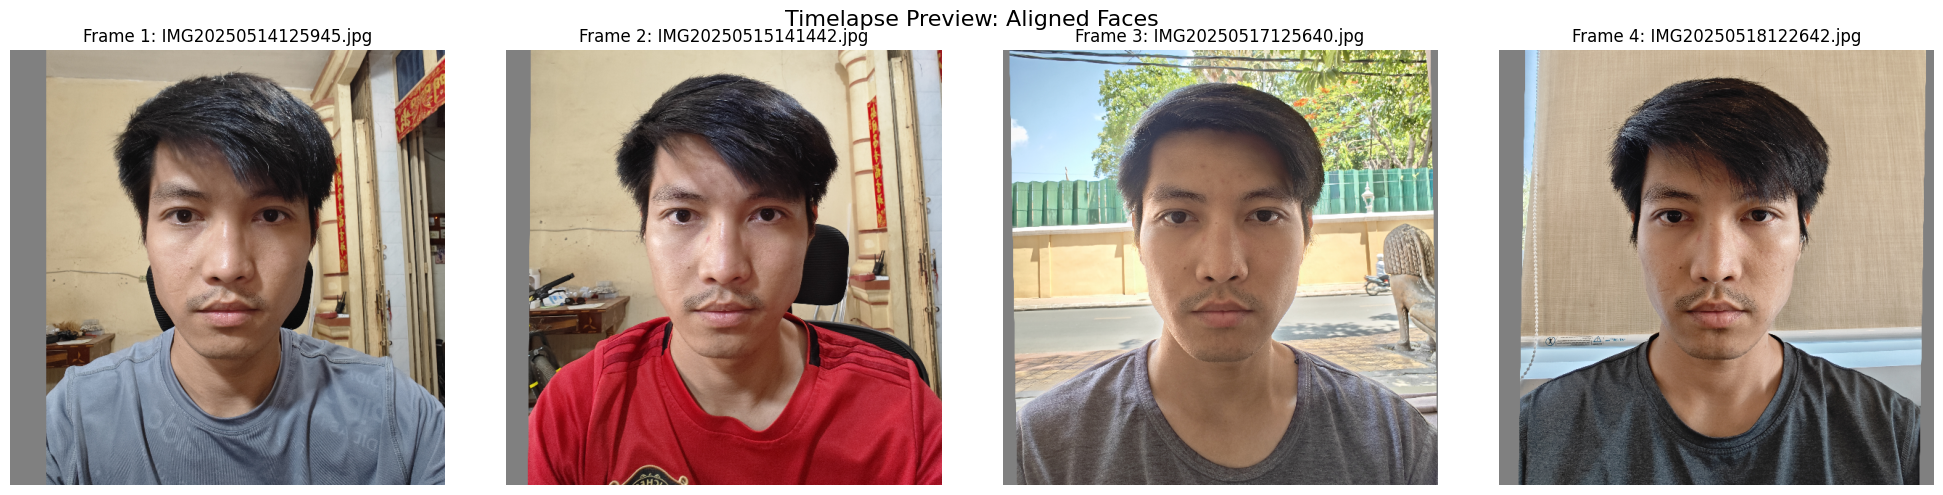

👀 Notice how all faces are now:
   - Same size and scale
   - Same position in the frame
   - Same rotation/orientation
   - Ready for smooth timelapse creation!

📈 Pipeline Summary:
   Input images: 227
   Faces detected: 225
   Landmarks extracted: 225
   Successfully aligned: 225
   Output images saved: 225
   Overall success rate: 99.1%

🎯 Next Steps for Premiere Pro:
   1. Open Premiere Pro
   2. Import > Media...
   3. Navigate to: c:\Users\Chimeng62\Desktop\daily_selfie_preprocessor_notebook\3_output_selfies
   4. Select the first frame (frame_0001.jpg) in any subdirectory
   5. Check 'Image Sequence' option in import dialog
   6. Set frame rate (e.g., 10 fps for slower, 30 fps for faster)
   7. Click Import - Premiere will automatically import all sequential frames!

   Alternative FFmpeg commands:
   - From specific subdirectory:
     ffmpeg -framerate 10 -i 'c:\Users\Chimeng62\Desktop\daily_selfie_preprocessor_notebook\3_output_selfies/[subdirectory]/frame_%04d.jpg' -c:v libx

In [10]:
# Output Generation
print("=== STEP 9: OUTPUT GENERATION ===")

if 'aligned_images' in locals() and len(aligned_images) > 0:
    print(f"Saving {len(aligned_images)} aligned images...")
    
    saved_files = []
    save_failures = []
    
    # Sort aligned images by original filename to maintain chronological order
    aligned_images_sorted = sorted(aligned_images, key=lambda x: x['name'])
    
    for idx, data in enumerate(tqdm(aligned_images_sorted, desc="Saving aligned images")):
        try:
            # Determine the subdirectory from the original image path
            original_path = Path(data['path'])
            
            # Get relative path from source base directory
            try:
                rel_path = original_path.relative_to(source_base_dir)
                if rel_path.parent == Path('.'):
                    # Image is in root directory
                    subdir_name = "root"
                else:
                    # Image is in a subdirectory, use the first level directory name
                    subdir_name = rel_path.parts[0]
            except ValueError:
                # Fallback if relative path calculation fails
                subdir_name = original_path.parent.name
            
            # Create subdirectory-specific output directory
            subdir_output_dir = output_base_dir / subdir_name
            subdir_output_dir.mkdir(parents=True, exist_ok=True)
            
            # Generate sequential filename for Premiere Pro import
            # Format: frame_0001.jpg, frame_0002.jpg, etc.
            output_filename = f"frame_{idx+1:04d}.jpg"
            output_path = subdir_output_dir / output_filename
            
            # Save the aligned image
            success = cv2.imwrite(str(output_path), data['aligned'])
            
            if success:
                saved_files.append(output_path)
            else:
                save_failures.append(data['name'])
                print(f"Failed to save {data['name']}")
                
        except Exception as e:
            save_failures.append(data['name'])
            print(f"Error saving {data['name']}: {str(e)}")
    
    print(f"\n📊 Output Results:")
    print(f"✅ Successfully saved: {len(saved_files)} images")
    print(f"❌ Failed saves: {len(save_failures)}")
    print(f"📁 Output base directory: {output_base_dir}")
    
    # Show distribution by subdirectory
    if saved_files:
        from collections import defaultdict
        subdir_counts = defaultdict(int)
        for file_path in saved_files:
            subdir_counts[file_path.parent.name] += 1
        
        print(f"\n📋 Saved images by subdirectory:")
        for subdir in sorted(subdir_counts.keys()):
            print(f"  {subdir}: {subdir_counts[subdir]} images")
        
        print(f"\n📋 Sample output files (sequential naming):")
        for i, file_path in enumerate(saved_files[:5]):
            file_size = file_path.stat().st_size / 1024  # KB
            subdir = file_path.parent.name
            print(f"  {i+1}. {subdir}/{file_path.name} ({file_size:.1f} KB)")
        if len(saved_files) > 5:
            print(f"  ... and {len(saved_files) - 5} more files")
    
    # Create a timelapse preview (side-by-side comparison of first few images)
    if len(aligned_images) >= 4:
        print(f"\n🎬 Creating Timelapse Preview:")
        
        # Show aligned images in sequence to preview the timelapse effect
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))
        
        for i in range(4):
            data = aligned_images[i]
            axes[i].imshow(cv2.cvtColor(data['aligned'], cv2.COLOR_BGR2RGB))
            axes[i].set_title(f"Frame {i+1}: {data['name']}")
            axes[i].axis('off')
        
        plt.suptitle("Timelapse Preview: Aligned Faces", fontsize=16)
        plt.tight_layout()
        plt.show()
        
        print("👀 Notice how all faces are now:")
        print("   - Same size and scale")
        print("   - Same position in the frame") 
        print("   - Same rotation/orientation")
        print("   - Ready for smooth timelapse creation!")
    
    # Summary statistics
    if len(aligned_images) > 1:
        print(f"\n📈 Pipeline Summary:")
        print(f"   Input images: {len(image_files)}")
        print(f"   Faces detected: {len(face_data) if 'face_data' in locals() else 0}")
        print(f"   Landmarks extracted: {len(landmark_data) if 'landmark_data' in locals() else 0}")
        print(f"   Successfully aligned: {len(aligned_images)}")
        print(f"   Output images saved: {len(saved_files)}")
        
        success_rate = (len(saved_files) / len(image_files)) * 100
        print(f"   Overall success rate: {success_rate:.1f}%")
        
        print(f"\n🎯 Next Steps for Premiere Pro:")
        print(f"   1. Open Premiere Pro")
        print(f"   2. Import > Media...")
        print(f"   3. Navigate to: {output_base_dir}")
        print(f"   4. Select the first frame (frame_0001.jpg) in any subdirectory")
        print(f"   5. Check 'Image Sequence' option in import dialog")
        print(f"   6. Set frame rate (e.g., 10 fps for slower, 30 fps for faster)")
        print(f"   7. Click Import - Premiere will automatically import all sequential frames!")
        print(f"")
        print(f"   Alternative FFmpeg commands:")
        print(f"   - From specific subdirectory:")
        print(f"     ffmpeg -framerate 10 -i '{output_base_dir}/[subdirectory]/frame_%04d.jpg' -c:v libx264 timelapse.mp4")
        print(f"   - Combine all subdirectories first, then create video")
        
    print(f"\n🎉 FACIAL ALIGNMENT PIPELINE COMPLETED!")
    print(f"💡 Files now use sequential naming (frame_0001.jpg, frame_0002.jpg, etc.)")
    print(f"   Perfect for importing as image sequence in Premiere Pro!")
    
else:
    print("❌ Cannot generate output: No aligned images available")
    print("   Please ensure previous steps completed successfully")